# Football Match Predictions

In [440]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import autoreload
import missingno as msno
import os
import csv
import sys
import requests

from bs4 import BeautifulSoup
from collections import defaultdict, Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

sb.set_style('whitegrid')

In [178]:
odds_df = pd.read_csv("D:\Open Classroom\Datasets\Football Matches Odds\Matches_Odds.csv")
results_df = pd.read_csv("D:\Open Classroom\Datasets\Football Matches Odds\Matches_Results.csv")

In [179]:
df = pd.merge(odds_df, results_df, on='match_id')
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,date_start_y,competition_name_y,home_team_name_y,away_team_name_y,home_team_score,away_team_score,final_result,result
0,1,12/26/2016 12:30,Eng. Premier League,12/26/2016 12:00,Watford,Crystal Palace,2.35,3.1,3.10,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
1,1,12/26/2016 12:30,Eng. Premier League,12/26/2016 6:45,Watford,Crystal Palace,2.40,3.0,3.25,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
2,1,12/26/2016 12:30,Eng. Premier League,12/26/2016 3:35,Watford,Crystal Palace,2.40,3.1,3.10,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
3,1,12/26/2016 12:30,Eng. Premier League,12/23/2016 19:45,Watford,Crystal Palace,2.45,2.9,3.25,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
4,1,12/26/2016 12:30,Eng. Premier League,12/25/2016 15:20,Watford,Crystal Palace,2.45,3.0,3.10,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D


In [180]:
df.shape

(466674, 17)

In [181]:
df.drop(columns = ['date_start_y', 'competition_name_y', 'home_team_name_y', 'away_team_name_y'], inplace=True)

In [182]:
df.isnull().sum()

match_id              0
date_start_x          0
competition_name_x    0
date_created          0
home_team_name_x      0
away_team_name_x      0
home_team_odd         0
away_team_odd         0
tie_odd               0
home_team_score       0
away_team_score       0
final_result          0
result                0
dtype: int64

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466674 entries, 0 to 466673
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   match_id            466674 non-null  int64  
 1   date_start_x        466674 non-null  object 
 2   competition_name_x  466674 non-null  object 
 3   date_created        466674 non-null  object 
 4   home_team_name_x    466674 non-null  object 
 5   away_team_name_x    466674 non-null  object 
 6   home_team_odd       466674 non-null  float64
 7   away_team_odd       466674 non-null  float64
 8   tie_odd             466674 non-null  float64
 9   home_team_score     466674 non-null  int64  
 10  away_team_score     466674 non-null  int64  
 11  final_result        466674 non-null  object 
 12  result              466674 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 46.3+ MB


In [184]:
df['date_start_x'] = pd.to_datetime(df['date_start_x'])
df['date_created'] = pd.to_datetime(df['date_created'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466674 entries, 0 to 466673
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   match_id            466674 non-null  int64         
 1   date_start_x        466674 non-null  datetime64[ns]
 2   competition_name_x  466674 non-null  object        
 3   date_created        466674 non-null  datetime64[ns]
 4   home_team_name_x    466674 non-null  object        
 5   away_team_name_x    466674 non-null  object        
 6   home_team_odd       466674 non-null  float64       
 7   away_team_odd       466674 non-null  float64       
 8   tie_odd             466674 non-null  float64       
 9   home_team_score     466674 non-null  int64         
 10  away_team_score     466674 non-null  int64         
 11  final_result        466674 non-null  object        
 12  result              466674 non-null  object        
dtypes: datetime64[ns](2), float64

In [185]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D


In [186]:
df['away_team_name_x'].value_counts()

away_team_name_x
Manchester United          680
Real Madrid                632
Celta Vigo                 618
Athletic Bilbao            585
Manchester City            564
                          ... 
Renaissance FC               1
Avondale United              1
Bluebell United              1
USD 1913 Seregno Calcio      1
US Tebessa                   1
Name: count, Length: 4677, dtype: int64

In [187]:
df['home_team_name_code'] = df['home_team_name_x'].astype('category').cat.codes
df['competition_name_code'] = df['competition_name_x'].astype('category').cat.codes
result_codes = {'W': 0, 'D': 1, 'L': 2}
df['results_code'] = df['result'].map(result_codes)
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1


In [188]:
df['results_code'].value_counts()

results_code
0    199623
2    149894
1    117157
Name: count, dtype: int64

In [189]:
df['result'].value_counts()

result
W    199623
L    149894
D    117157
Name: count, dtype: int64

In [190]:
df['match_time'] = df['date_start_x'].dt.time

In [191]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00


In [192]:
# df['hour'] = df['match_time'].str.replace(':.+', '', regex=True).astype('int')
df['hour'] = df['date_start_x'].dt.hour

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466674 entries, 0 to 466673
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   match_id               466674 non-null  int64         
 1   date_start_x           466674 non-null  datetime64[ns]
 2   competition_name_x     466674 non-null  object        
 3   date_created           466674 non-null  datetime64[ns]
 4   home_team_name_x       466674 non-null  object        
 5   away_team_name_x       466674 non-null  object        
 6   home_team_odd          466674 non-null  float64       
 7   away_team_odd          466674 non-null  float64       
 8   tie_odd                466674 non-null  float64       
 9   home_team_score        466674 non-null  int64         
 10  away_team_score        466674 non-null  int64         
 11  final_result           466674 non-null  object        
 12  result                 466674 non-null  obje

In [194]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00,12
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00,12
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00,12


In [195]:
df['day_name'] = df['date_start_x'].dt.day_name()
df['day_code'] = df['date_start_x'].dt.dayofweek

In [196]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0


In [197]:
# # Create a target column for the prediction analysis
# # Return a boolean value, if  result = 'w' returns 1, else returns 0
df['target'] = (df['result']=='W').astype('int')
df.head()

# # changed the target strategy to each label encoding format
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df['target'] = le.fit_transform(df['result'])
# df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0


In [198]:
from sklearn.preprocessing import LabelEncoder


def target_correlation():
    le = LabelEncoder()
    df_numeric = df.copy()
    
    for col in df_numeric.select_dtypes(include=['object']).columns:
        df_numeric[col] = le.fit_transform(df_numeric[col])
    
    plt.figure(figsize=(12, 4))
    plt.title("Pearsons Correlation of columns with Target Series", fontdict={'size':14})
    return df_numeric.select_dtypes(include=['float64', 'int64', "datetime", "int32"]).corr()['target'].plot(kind='bar')

<Axes: title={'center': 'Pearsons Correlation of columns with Target Series'}>

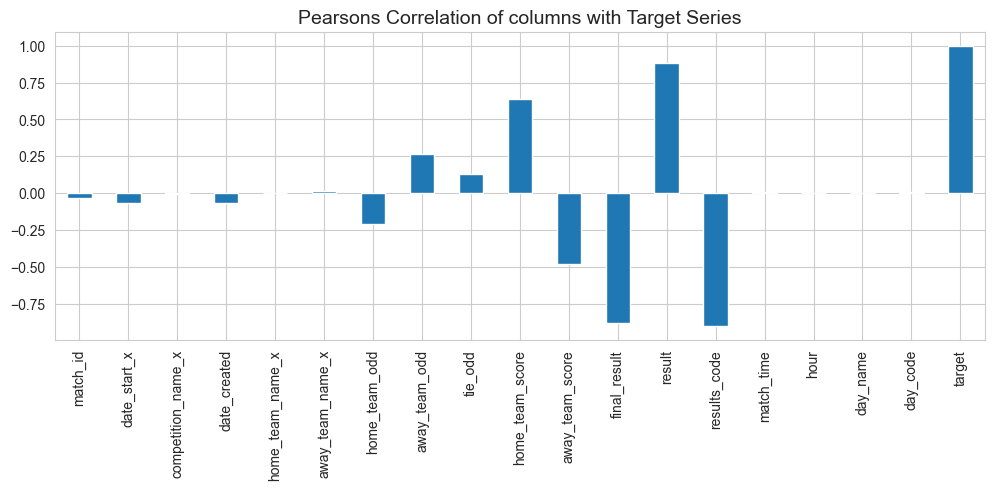

In [199]:
target_correlation()

In [200]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0


In [295]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

In [296]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=42)

In [297]:
le = LabelEncoder()
df['result2'] = le.fit_transform(df['result'])
df['date_start_x'].max()

Timestamp('2018-05-23 19:44:00')

In [298]:
train = df[df['date_start_x'] < '2018-01-01']
train['tie_odd'].head()

0    3.10
1    3.25
2    3.10
3    3.25
4    3.10
Name: tie_odd, dtype: float64

In [299]:
test = df[df['date_start_x'] > '2018-01-01']

In [304]:
# create a list of predictors for model evaluation

predictors = ['result2', 'home_team_score', 'tie_odd', 'away_team_odd']

In [309]:
cross_val_pred = cross_val_predict(rf, train[predictors], train['target'])
cross_val_pred

array([0, 0, 0, ..., 0, 0, 0])

In [311]:

scores = cross_val_score(rf, train[predictors], cross_val_pred, cv=5)  # 5-fold cross-validation
print("Cross-validation accuracy: ", scores.mean())


Cross-validation accuracy:  1.0


In [312]:
rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

In [313]:
preds = rf.predict(test[predictors])

In [314]:
from sklearn.metrics import accuracy_score

In [315]:
acc = accuracy_score(test['target'], preds)
acc

1.0

In [316]:
combined = pd.DataFrame(dict(actual=test['target'], predictions=preds))

In [317]:
pd.crosstab(index=combined['actual'], columns=combined['predictions'])

predictions,0,1
actual,,
0,28529,0
1,0,14260


In [318]:
from sklearn.metrics import precision_score

In [320]:
precision = precision_score(test['target'], preds)
print(f'Our prediction is actually {precision}% accurate everytime we predict a win, \nwhich is not a good outcome')

Our prediction is actually 1.0% accurate everytime we predict a win, 
which is not a good outcome


So we have tried cross validation to try improving the model from overfitting but still no success. Now we will implement hyperparameter tuning to randomize the search

In [321]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(train[predictors], train['target'])
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'max_depth': 10, 'n_estimators': 100}


In [326]:
grid_search.predict(train[predictors])

array([0, 0, 0, ..., 0, 0, 0])

In [329]:
grid_search.predict_proba(train[predictors])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Conclusion: Even with grid search we still couldnt achieve a better accurate model

In [215]:
# To improve the precision and accuracy scores we will have to use rolling averages 
# First we group the dataframe by home-team

grouped_df = df.groupby(df['home_team_name_x'])

group = grouped_df.get_group('Manchester United')
group.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2
18,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 15:00:00,Manchester United,Sunderland,1.17,15.0,6.75,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2
19,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 11:30:00,Manchester United,Sunderland,1.18,13.0,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2
20,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 11:45:00,Manchester United,Sunderland,1.18,13.5,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2
21,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-25 11:35:00,Manchester United,Sunderland,1.18,14.0,6.25,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2
22,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-23 16:24:00,Manchester United,Sunderland,1.18,14.0,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2


In [216]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date_start_x')
    rolling_stats = group[cols].rolling(window=3).mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [217]:
grouped_df = df.groupby(df['home_team_name_x'])
group = grouped_df.get_group('Manchester United')
cols = ['home_team_odd', 'away_team_odd', 'tie_odd', 'home_team_score', 'away_team_score']
new_cols = [f"{c}_rolling" for c in cols]

In [218]:
new_cols

['home_team_odd_rolling',
 'away_team_odd_rolling',
 'tie_odd_rolling',
 'home_team_score_rolling',
 'away_team_score_rolling']

In [219]:
rolling_averages(group, cols, new_cols).head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling
28,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 09:30:00,Manchester United,Sunderland,1.20,13.5,6.25,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2,1.190000,14.166667,6.416667,3.0,1.0
27,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 09:50:00,Manchester United,Sunderland,1.20,13.0,6.25,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2,1.200000,13.500000,6.250000,3.0,1.0
25,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-24 13:15:00,Manchester United,Sunderland,1.18,15.0,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2,1.193333,13.833333,6.333333,3.0,1.0
24,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-24 13:25:00,Manchester United,Sunderland,1.18,14.5,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2,1.186667,14.166667,6.416667,3.0,1.0
26,3,2016-12-26 15:00:00,Eng. Premier League,2016-12-26 12:00:00,Manchester United,Sunderland,1.20,12.5,6.50,3,1,1,W,2821,180,0,15:00:00,15,Monday,0,1,2,1.186667,14.000000,6.500000,3.0,1.0


In [220]:
matches_rolling = df.groupby("home_team_name_x").apply(lambda x: rolling_averages(x, cols, new_cols))

C:\Users\anton\AppData\Local\Temp\ipykernel_4672\1464642228.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = df.groupby("home_team_name_x").apply(lambda x: rolling_averages(x, cols, new_cols))


In [221]:
matches_rolling = matches_rolling.drop_duplicates(subset='match_id', keep='first')

In [222]:
matches_rolling.head()

match_id        date_start_x  \
home_team_name_x                                                     
07 Vestur                     202490    665094 2017-04-30 15:00:00   
                              316334    684178 2017-07-22 17:00:00   
                              383622    694150 2017-08-24 18:30:00   
1. FC Germ Egestorf/Langreder 116823    123655 2017-03-12 14:00:00   
                              139215    155299 2017-03-25 14:00:00   

                                                competition_name_x  \
home_team_name_x                                                     
07 Vestur                     202490  Faroe Islands Premier League   
                              316334      Faroe Islands Pr. League   
                              383622      Faroe Islands Pr. League   
1. FC Germ Egestorf/Langreder 116823       German Regionall. North   
                              139215       German Regionall. North   

                                            date_created  \
home_team_name_x                                           
07 Vestur                     202490 2017-04-29 20:00:00   
                              316334 2017-07-22 15:50:00   
                              383622 2017-08-24 06:30:00   
1. FC Germ Egestorf/Langreder 116823 2017-03-11 21:45:00   
                              139215 2017-03-23 11:50:00   

                                                   home_team_name_x  \
home_team_name_x                                                      
07 Vestur                     202490                      07 Vestur   
                              316334                      07 Vestur   
                              383622                      07 Vestur   
1. FC Germ Egestorf/Langreder 116823  1. FC Germ Egestorf/Langreder   
                              139215  1. FC Germ Egestorf/Langreder   

                                     away_team_name_x  home_team_odd  \
home_team_name_x                                                       
07 Vestur                     202490         Skala IF           2.05   
                              316334          Runavik           6.00   
                              383622    Kֳ Klaksvֳ­k           7.25   
1. FC Germ Egestorf/Langreder 116823        Oldenburg           2.75   
                              139215          Eichede           2.30   

                                      away_team_odd  tie_odd  home_team_score  \
home_team_name_x                                                                
07 Vestur                     202490           3.25     3.15                1   
                              316334           1.38     4.50                0   
                              383622           1.27     5.50                1   
1. FC Germ Egestorf/Langreder 116823           2.30     3.20                0   
                              139215           2.75     3.25                3   

                                      away_team_score final_result result  \
home_team_name_x                                                            
07 Vestur                     202490                1            x      D   
                              316334                7            2      L   
                              383622                1            x      D   
1. FC Germ Egestorf/Langreder 116823                1            2      L   
                              139215                0            1      W   

                                      home_team_name_code  \
home_team_name_x                                            
07 Vestur                     202490                    0   
                              316334                    0   
                              383622                    0   
1. FC Germ Egestorf/Langreder 116823                    1   
                              139215                    1   

                                      competition_name_code  results_code  \
home_team_name_x   

In [223]:
matches_rolling = matches_rolling.droplevel('home_team_name_x')
matches_rolling.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling
202490,665094,2017-04-30 15:00:00,Faroe Islands Premier League,2017-04-29 20:00:00,07 Vestur,Skala IF,2.05,3.25,3.15,1,1,x,D,0,203,1,15:00:00,15,Sunday,6,0,0,2.016667,3.316667,3.166667,1.000000,1.000000
316334,684178,2017-07-22 17:00:00,Faroe Islands Pr. League,2017-07-22 15:50:00,07 Vestur,Runavik,6.00,1.38,4.50,0,7,2,L,0,202,2,17:00:00,17,Saturday,5,0,1,3.366667,2.643333,3.616667,0.666667,3.000000
383622,694150,2017-08-24 18:30:00,Faroe Islands Pr. League,2017-08-24 06:30:00,07 Vestur,Kֳ Klaksvֳ­k,7.25,1.27,5.50,1,1,x,D,0,202,1,18:30:00,18,Thursday,3,0,0,6.833333,1.343333,4.733333,0.333333,5.000000
116823,123655,2017-03-12 14:00:00,German Regionall. North,2017-03-11 21:45:00,1. FC Germ Egestorf/Langreder,Oldenburg,2.75,2.30,3.20,0,1,2,L,1,237,2,14:00:00,14,Sunday,6,0,1,2.716667,2.316667,3.200000,0.000000,1.000000
139215,155299,2017-03-25 14:00:00,German Regionall. North,2017-03-23 11:50:00,1. FC Germ Egestorf/Langreder,Eichede,2.30,2.75,3.25,3,0,1,W,1,237,0,14:00:00,14,Saturday,5,1,2,2.700000,2.366667,3.233333,1.000000,0.666667


In [330]:
matches_rolling.index = range(matches_rolling.shape[0])
matches_rolling.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling
0,665094,2017-04-30 15:00:00,Faroe Islands Premier League,2017-04-29 20:00:00,07 Vestur,Skala IF,2.05,3.25,3.15,1,1,x,D,0,203,1,15:00:00,15,Sunday,6,0,0,2.016667,3.316667,3.166667,1.000000,1.000000
1,684178,2017-07-22 17:00:00,Faroe Islands Pr. League,2017-07-22 15:50:00,07 Vestur,Runavik,6.00,1.38,4.50,0,7,2,L,0,202,2,17:00:00,17,Saturday,5,0,1,3.366667,2.643333,3.616667,0.666667,3.000000
2,694150,2017-08-24 18:30:00,Faroe Islands Pr. League,2017-08-24 06:30:00,07 Vestur,Kֳ Klaksvֳ­k,7.25,1.27,5.50,1,1,x,D,0,202,1,18:30:00,18,Thursday,3,0,0,6.833333,1.343333,4.733333,0.333333,5.000000
3,123655,2017-03-12 14:00:00,German Regionall. North,2017-03-11 21:45:00,1. FC Germ Egestorf/Langreder,Oldenburg,2.75,2.30,3.20,0,1,2,L,1,237,2,14:00:00,14,Sunday,6,0,1,2.716667,2.316667,3.200000,0.000000,1.000000
4,155299,2017-03-25 14:00:00,German Regionall. North,2017-03-23 11:50:00,1. FC Germ Egestorf/Langreder,Eichede,2.30,2.75,3.25,3,0,1,W,1,237,0,14:00:00,14,Saturday,5,1,2,2.700000,2.366667,3.233333,1.000000,0.666667


In [332]:
def target_correlation_for_rolling_avg():
    le = LabelEncoder()
    df_numeric = df.copy()
    
    for col in df_numeric.select_dtypes(include=['object']).columns:
        df_numeric[col] = le.fit_transform(df_numeric[col])
    
    plt.figure(figsize=(12, 4))
    plt.title("Pearsons Correlation of columns with Target Series", fontdict={'size':14})
    return df_numeric.select_dtypes(include=['float64', 'int64', "datetime", "int32"]).corr()['target'].plot(kind='bar')

<Axes: title={'center': 'Pearsons Correlation of columns with Target Series'}>

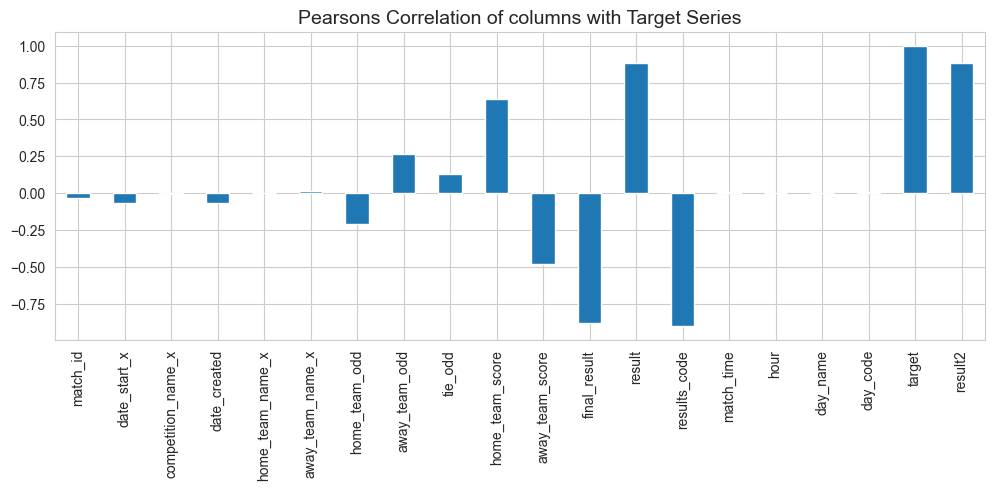

In [333]:
target_correlation_for_rolling_avg()

In [343]:
def make_predictions(data, model):
    train = df[df['date_start_x'] < '2018-01-01']
    test = df[df['date_start_x'] > '2018-01-01']
    predictors = ['home_team_odd', 'away_team_odd', 'tie_odd', 'home_team_score', 'away_team_score']
    model.fit(train[predictors], train['target'])
    preds = rf.predict(test[predictors])
    acc = accuracy_score(test['target'], preds)
    combined = pd.DataFrame(dict(actual=test['target'], predictions=preds))
    precision = precision_score(test['target'], preds)
    return combined, precision, acc

In [344]:
combined, precision, acc = make_predictions(matches_rolling, rf)

In [345]:
combined.head()

,actual,predictions
421020,1,1
421021,1,1
421022,1,1
421023,1,1
421024,1,1


In [346]:
combined.index

Index([421020, 421021, 421022, 421023, 421024, 421025, 421026, 421027, 421028,
       421029,
       ...
       466664, 466665, 466666, 466667, 466668, 466669, 466670, 466671, 466672,
       466673],
      dtype='int64', length=42789)

In [347]:
matches_rolling.shape

(31619, 27)

In [348]:
precision

np.float64(0.9988792378817596)

In [349]:
acc

0.9996260721213396

In [232]:
new_df = pd.concat([matches_rolling, combined], axis=1)

In [233]:
new_df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling,actual,predictions
0,665094.0,2017-04-30 15:00:00,Faroe Islands Premier League,2017-04-29 20:00:00,07 Vestur,Skala IF,2.05,3.25,3.15,1.0,1.0,x,D,0.0,203.0,1.0,15:00:00,15.0,Sunday,6.0,0.0,0.0,2.016667,3.316667,3.166667,1.000000,1.000000,NaN,NaN
1,684178.0,2017-07-22 17:00:00,Faroe Islands Pr. League,2017-07-22 15:50:00,07 Vestur,Runavik,6.00,1.38,4.50,0.0,7.0,2,L,0.0,202.0,2.0,17:00:00,17.0,Saturday,5.0,0.0,1.0,3.366667,2.643333,3.616667,0.666667,3.000000,NaN,NaN
2,694150.0,2017-08-24 18:30:00,Faroe Islands Pr. League,2017-08-24 06:30:00,07 Vestur,Kֳ Klaksvֳ­k,7.25,1.27,5.50,1.0,1.0,x,D,0.0,202.0,1.0,18:30:00,18.0,Thursday,3.0,0.0,0.0,6.833333,1.343333,4.733333,0.333333,5.000000,NaN,NaN
3,123655.0,2017-03-12 14:00:00,German Regionall. North,2017-03-11 21:45:00,1. FC Germ Egestorf/Langreder,Oldenburg,2.75,2.30,3.20,0.0,1.0,2,L,1.0,237.0,2.0,14:00:00,14.0,Sunday,6.0,0.0,1.0,2.716667,2.316667,3.200000,0.000000,1.000000,NaN,NaN
4,155299.0,2017-03-25 14:00:00,German Regionall. North,2017-03-23 11:50:00,1. FC Germ Egestorf/Langreder,Eichede,2.30,2.75,3.25,3.0,0.0,1,W,1.0,237.0,0.0,14:00:00,14.0,Saturday,5.0,1.0,2.0,2.700000,2.366667,3.233333,1.000000,0.666667,NaN,NaN


In [352]:
new_df[new_df['actual'] != np.nan].head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling,actual,predictions
0,665094.0,2017-04-30 15:00:00,Faroe Islands Premier League,2017-04-29 20:00:00,07 Vestur,Skala IF,2.05,3.25,3.15,1.0,1.0,x,D,0.0,203.0,1.0,15:00:00,15.0,Sunday,6.0,0.0,0.0,2.016667,3.316667,3.166667,1.000000,1.000000,NaN,NaN
1,684178.0,2017-07-22 17:00:00,Faroe Islands Pr. League,2017-07-22 15:50:00,07 Vestur,Runavik,6.00,1.38,4.50,0.0,7.0,2,L,0.0,202.0,2.0,17:00:00,17.0,Saturday,5.0,0.0,1.0,3.366667,2.643333,3.616667,0.666667,3.000000,NaN,NaN
2,694150.0,2017-08-24 18:30:00,Faroe Islands Pr. League,2017-08-24 06:30:00,07 Vestur,Kֳ Klaksvֳ­k,7.25,1.27,5.50,1.0,1.0,x,D,0.0,202.0,1.0,18:30:00,18.0,Thursday,3.0,0.0,0.0,6.833333,1.343333,4.733333,0.333333,5.000000,NaN,NaN
3,123655.0,2017-03-12 14:00:00,German Regionall. North,2017-03-11 21:45:00,1. FC Germ Egestorf/Langreder,Oldenburg,2.75,2.30,3.20,0.0,1.0,2,L,1.0,237.0,2.0,14:00:00,14.0,Sunday,6.0,0.0,1.0,2.716667,2.316667,3.200000,0.000000,1.000000,NaN,NaN
4,155299.0,2017-03-25 14:00:00,German Regionall. North,2017-03-23 11:50:00,1. FC Germ Egestorf/Langreder,Eichede,2.30,2.75,3.25,3.0,0.0,1,W,1.0,237.0,0.0,14:00:00,14.0,Saturday,5.0,1.0,2.0,2.700000,2.366667,3.233333,1.000000,0.666667,NaN,NaN


In [358]:
merged_df = combined.merge(matches_rolling[['date_start_x', 'competition_name_x', 'home_team_name_x', 'away_team_name_x']], left_index=True, right_index=True)

In [360]:
matches_rolling.shape, combined.shape

((31619, 27), (42789, 2))

In [362]:
matches_rolling.index, combined.index

(RangeIndex(start=0, stop=31619, step=1),
 Index([421020, 421021, 421022, 421023, 421024, 421025, 421026, 421027, 421028,
        421029,
        ...
        466664, 466665, 466666, 466667, 466668, 466669, 466670, 466671, 466672,
        466673],
       dtype='int64', length=42789))

In [363]:
matches_rolling.shape[0] - combined.shape[0]

-11170

In [364]:
# matches_rolling[['date_start_x', 'competition_name_x', 'home_team_name_x', 'away_team_name_x']].merge(combined, left_on=matches_rolling, right_on=combined)

In [236]:
merged_df.head()

,actual,predictions,date_start_x,competition_name_x,home_team_name_x,away_team_name_x


In [237]:
matches_rolling.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2,home_team_odd_rolling,away_team_odd_rolling,tie_odd_rolling,home_team_score_rolling,away_team_score_rolling
0,665094,2017-04-30 15:00:00,Faroe Islands Premier League,2017-04-29 20:00:00,07 Vestur,Skala IF,2.05,3.25,3.15,1,1,x,D,0,203,1,15:00:00,15,Sunday,6,0,0,2.016667,3.316667,3.166667,1.000000,1.000000
1,684178,2017-07-22 17:00:00,Faroe Islands Pr. League,2017-07-22 15:50:00,07 Vestur,Runavik,6.00,1.38,4.50,0,7,2,L,0,202,2,17:00:00,17,Saturday,5,0,1,3.366667,2.643333,3.616667,0.666667,3.000000
2,694150,2017-08-24 18:30:00,Faroe Islands Pr. League,2017-08-24 06:30:00,07 Vestur,Kֳ Klaksvֳ­k,7.25,1.27,5.50,1,1,x,D,0,202,1,18:30:00,18,Thursday,3,0,0,6.833333,1.343333,4.733333,0.333333,5.000000
3,123655,2017-03-12 14:00:00,German Regionall. North,2017-03-11 21:45:00,1. FC Germ Egestorf/Langreder,Oldenburg,2.75,2.30,3.20,0,1,2,L,1,237,2,14:00:00,14,Sunday,6,0,1,2.716667,2.316667,3.200000,0.000000,1.000000
4,155299,2017-03-25 14:00:00,German Regionall. North,2017-03-23 11:50:00,1. FC Germ Egestorf/Langreder,Eichede,2.30,2.75,3.25,3,0,1,W,1,237,0,14:00:00,14,Saturday,5,1,2,2.700000,2.366667,3.233333,1.000000,0.666667


In [238]:
matches_rolling['home_team_name_x'].value_counts().head(20)

home_team_name_x
Huddersfield          28
Celta Vigo            27
Grimsby               26
Exeter                25
Plymouth Argyle       25
Ipswich               24
Fleetwood             24
Hull                  24
Manchester United     24
Milton Keynes Dons    24
QPR                   24
Juventus              24
Stevenage             23
Flamengo              23
Monaco                23
Crewe                 23
Mainz                 23
Luton                 23
Millwall              23
Bury                  23
Name: count, dtype: int64

In [239]:
matches_rolling['away_team_name_x'].value_counts().head(20)

away_team_name_x
Lincoln              30
Manchester United    28
Athletic Bilbao      27
Celta Vigo           27
Wycombe              26
KRC Genk             25
Coventry             25
Atletico Nacional    25
Real Madrid          25
Macclesfield         25
Hoffenheim           24
Vitoria Guimaraes    24
Cheltenham           24
Dundee United        24
Bradford             24
Rochdale             24
Manchester City      24
Borussia Dortmund    24
Villarreal           24
Cardiff              24
Name: count, dtype: int64

In [240]:
combined.index.dtype

dtype('int64')

In [241]:
matches_rolling.index.dtype

dtype('int64')

In [242]:
combined.head()

,actual,predictions
421020,1,1
421021,1,1
421022,1,1
421023,1,1
421024,1,1


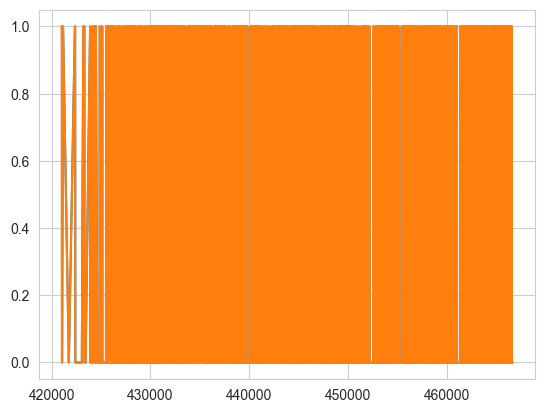

In [243]:
plt.plot(combined['actual'])
plt.plot(combined['predictions'])

In [373]:

def get_nums(df):
    num_cat = []
    for i in df.select_dtypes(include=['float64', 'int64']):
        num_cat.append(i)
    
    plt.figure(figsize=(10, 6))
    sb.heatmap(df[num_cat].corr(), annot=True, linewidths=0.5, cmap='viridis')
    plt.title('Pearsons Correlation of Columns', fontdict={'size': 14})

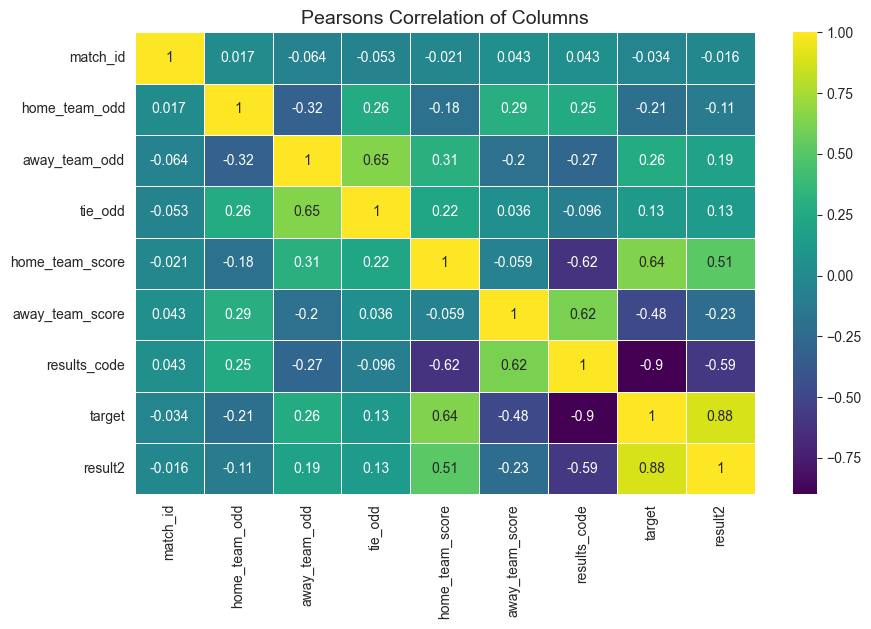

In [374]:
get_nums(df)

Text(0.5, 1.0, "Monotonic relationship with Spearman's \nCorrelation of Columns against the Results_code ")

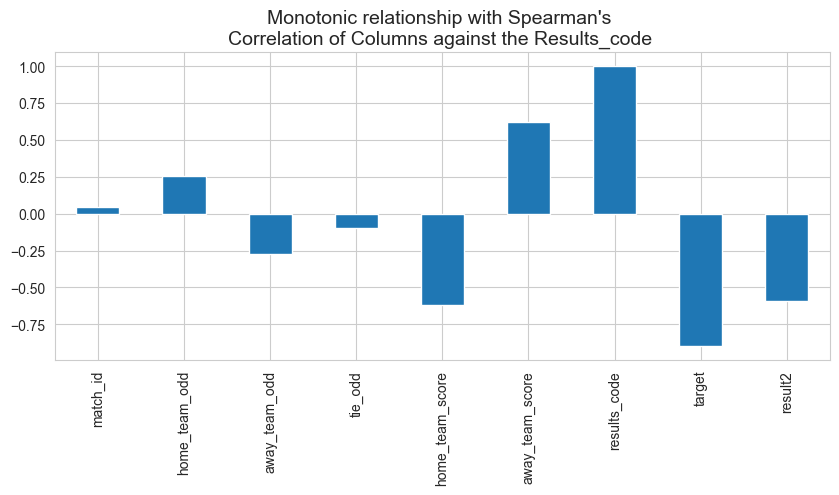

In [378]:
plt.figure(figsize=(10, 4))
df.select_dtypes(include=['float64', 'int64']).corr()['results_code'].plot(kind='bar')
plt.title("Monotonic relationship with Spearman's \nCorrelation of Columns against the Results_code ", fontdict={'size': 14})

In [247]:
def get_all_col_series(df):
    le = LabelEncoder()
    df2 = df.copy()
    # cols = df.select_dtypes(include=['float64', 'object', 'int64'])
    all_cols = []
    for i in df2.columns:
        if df2[i].dtypes == 'object':
            df2[i] = le.fit_transform(df2[i])
        all_cols.append(i)
    print(all_cols)
    plt.figure(figsize=(14, 10))
    sb.heatmap(df2[all_cols].corr(), annot=True, linewidths=0.8)
    plt.title('Pearsons Correlation of all Column Series', fontdict={'size': 14})
    
        

['match_id', 'date_start_x', 'competition_name_x', 'date_created', 'home_team_name_x', 'away_team_name_x', 'home_team_odd', 'away_team_odd', 'tie_odd', 'home_team_score', 'away_team_score', 'final_result', 'result', 'home_team_name_code', 'competition_name_code', 'results_code', 'match_time', 'hour', 'day_name', 'day_code', 'target', 'result2']


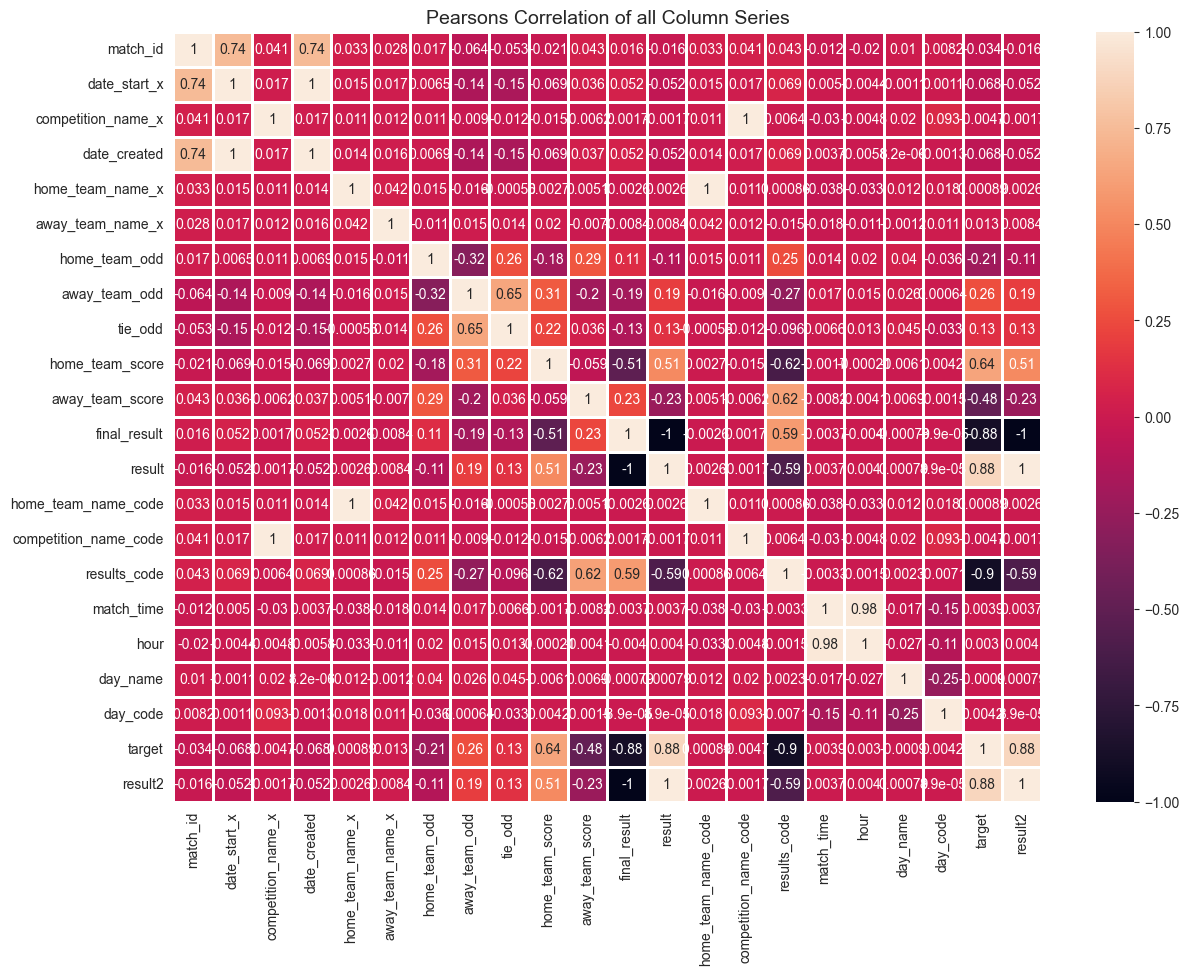

In [248]:
get_all_col_series(df)

In [249]:
for i in df.columns:
    if df[i].dtypes == 'object':
        print(i)
    # print(lambda x: x if x.dtype=='string' else x)

competition_name_x
home_team_name_x
away_team_name_x
final_result
result
match_time
day_name


In [396]:
df_copy = df[['home_team_name_x', 'home_team_odd', 'away_team_name_x', 'away_team_odd', 'tie_odd', 'target']]
df_copy.head()

,home_team_name_x,home_team_odd,away_team_name_x,away_team_odd,tie_odd,target
0,Watford,2.35,Crystal Palace,3.1,3.10,0
1,Watford,2.40,Crystal Palace,3.0,3.25,0
2,Watford,2.40,Crystal Palace,3.1,3.10,0
3,Watford,2.45,Crystal Palace,2.9,3.25,0
4,Watford,2.45,Crystal Palace,3.0,3.10,0


In [471]:
def run_experiment(home_team_name_x, home_team_odd, away_team_name_x, away_team_odd, draw_odd):
    
    data = pd.DataFrame(data={'home_team_name_x':[home_team_name_x], 'home_team_odd':[home_team_odd], 'away_team_name_x':[away_team_name_x], 'away_team_odd':[away_team_odd], 'tie_odd':[draw_odd]})
    print(data.head())

    
    # Load data and preprocess it
    df = pd.merge(odds_df, results_df, on='match_id')
    
    df['home_team_win'] = (df['home_team_score'] > df['away_team_score']).astype(int)
    df['away_team_win'] = (df['away_team_score'] < df['away_team_score']).astype(int)
    df['draw'] = (df['home_team_score'] == df['away_team_score']).astype(int)
    df['target'] = df['home_team_win']
    # df['target'][(df['home_team_win'] == 0) & (df['away_team_win'] == 0)] = 2
    df['target'] = (df['result']=='W').astype('int64')

    df_copy = df[['home_team_name_x', 'home_team_odd', 'away_team_name_x', 'away_team_odd', 'tie_odd', 'target']]
    
    # Filter data based on input teams and odds
    # mask = ((df_copy['home_team_name_x'] == home_team_name) & (df_copy['home_team_odd'] == home_team_odds) &
    #         (df_copy['away_team_name_x'] == away_team_name) & (df_copy['away_team_odd'] == away_team_odds) &
    #         (df_copy['tie_odd'] == draw_odds))
    # df_copy = pd.concat({'home_team_name_x': home_team_name_x, 'home_team_odd': home_team_odd, 'away_team_name_x': away_team_name_x, 'away_team_odd': away_team_odd, 'tie_odd': draw_odd},
                      # ignore_index=True)
    df_copy_copy = pd.concat([df_copy, data], ignore_index=True)
    
    # data = df_copy[mask]

    df_copy.head()
    
    # Train and evaluate model
    if not data.empty:
        # train_copy = df_copy[df_copy['date_start_x'] < '2018-01-01']
        # test_copy = df_copy[df_copy['date_start_x'] > '2018-01-01']
        # predictors = [home_team_name_x, home_team_odd, away_team_name_x, away_team_odd, tie_odd]
        # # predictors = df_copy.drop(columns=['target'])
        # rf.fit(train_copy[predictors], train_copy['target'])
        # preds = rf.predict(test_copy[predictors])
        # combined = pd.DataFrame(dict(actual=data['target'], predictions=preds))
        # precision = precision_score(data['target'], preds)
        # acc = accuracy_score(data['target'], preds)
        # print('Data not Empy')
        ###########################################
        x = data
        y = df_copy['target']

        for i in x.select_dtypes(include=['object']):
            x[i] = le.fit_transform(x[i])

        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

        rf.fit(x_train, y_train)
        preds = rf.predict(data)
        # combined = pd.DataFrame(dict(actual=y_train['target'], predictions=preds))
        precision = precision_score(y_train, preds)
        acc = accuracy_score(y_train, preds)
        print('So far we have achieved an accuracy score :', acc)

        # print('Data not Empy')
    else:
        # Return empty DataFrame
        combined = pd.DataFrame()
        precision = 0
        acc = 0
        print('Dataset is empty')
    
    return preds


In [472]:
run_experiment('Huddersfield', 2.64, 'Lincoln', 2.32, 3.83)


  home_team_name_x  home_team_odd away_team_name_x  away_team_odd  tie_odd
0     Huddersfield           2.64          Lincoln           2.32     3.83


ValueError: Found input variables with inconsistent numbers of samples: [1, 466674]

In [382]:
home_team_name_x = "Huddersfield"
home_team_odd = 2.15
away_team_name_x = "Lincoln"
away_team_odd = 2.90
tie_odd = 3.34



mask = ((df['home_team_name_x'] == home_team_name_x) & (df['home_team_odd'] == home_team_odd) &
            (df['away_team_name_x'] == away_team_name_x) & (df['away_team_odd'] == away_team_odd) &
            (df['tie_odd'] == tie_odd))

# df2 = df[home_team_name
df2 = df[mask]
df2.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2


In [253]:
df.head()

,match_id,date_start_x,competition_name_x,date_created,home_team_name_x,away_team_name_x,home_team_odd,away_team_odd,tie_odd,home_team_score,away_team_score,final_result,result,home_team_name_code,competition_name_code,results_code,match_time,hour,day_name,day_code,target,result2
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0,0
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0,0
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0,0
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0,0
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,1,1,x,D,4678,180,1,12:30:00,12,Monday,0,0,0


In [254]:

results_df = pd.read_csv(r"D:\Open Classroom\Datasets\Football Matches Odds\Matches_Results.csv")

def manual_testing(model, data, train, predictors):
    pred_data = data[predictors]
    pred_data = pred_data.values.reshape(-1, len(predictors))
    model.fit(train[predictors], train['target'])
    preds = model.predict(pred_data)
    win_pct = round((preds.mean() * 100), 2)
    precision = precision_score(data['target'], preds)
    accuracy = accuracy_score(data['target'], preds)
    if preds.mean() > 0.5:
        winning_team = data['home_team_name_x'].iloc[0]
    elif preds.mean() < 0.5:
        winning_team = data['away_team_name_x'].iloc[0]
    else:
        winning_team = 'Draw'
    results = {'winning_team': winning_team, 'pct_winning': win_pct, 'precision_score': precision,
               'accuracy_score': accuracy, 'predicted_values': preds}
    return results


In [256]:
# manual_testing(

In [257]:
results_df = pd.read_csv(r"D:\Open Classroom\Datasets\Football Matches Odds\Matches_Results.csv")

results_df.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result
0,1,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
1,2,12/26/2016 15:00,Eng. Premier League,Burnley,Middlesbrough,1,0,1,W
2,3,12/26/2016 15:00,Eng. Premier League,Manchester United,Sunderland,3,1,1,W
3,4,12/26/2016 15:00,Eng. Premier League,Swansea,West Ham,1,4,2,L
4,5,12/26/2016 15:00,Eng. Premier League,Arsenal,West Bromwich Albion,1,0,1,W


In [258]:
results_df.shape

(32508, 9)

In [259]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32508 entries, 0 to 32507
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   match_id          32508 non-null  int64 
 1   date_start        32508 non-null  object
 2   competition_name  32508 non-null  object
 3   home_team_name    32508 non-null  object
 4   away_team_name    32508 non-null  object
 5   home_team_score   32508 non-null  int64 
 6   away_team_score   32508 non-null  int64 
 7   final_result      32508 non-null  object
 8   result            32508 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.2+ MB


In [260]:
results_df.describe()

,match_id,home_team_score,away_team_score
count,32508.000000,32508.000000,32508.000000
mean,424020.677033,1.474806,1.207487
std,300904.706518,1.318136,1.202911
min,1.000000,0.000000,0.000000
25%,98475.750000,1.000000,0.000000
50%,661388.500000,1.000000,1.000000
75%,683451.250000,2.000000,2.000000
max,844769.000000,13.000000,18.000000


In [261]:
results_df.isnull().sum()

match_id            0
date_start          0
competition_name    0
home_team_name      0
away_team_name      0
home_team_score     0
away_team_score     0
final_result        0
result              0
dtype: int64

In [262]:
results_df.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result
0,1,12/26/2016 12:30,Eng. Premier League,Watford,Crystal Palace,1,1,x,D
1,2,12/26/2016 15:00,Eng. Premier League,Burnley,Middlesbrough,1,0,1,W
2,3,12/26/2016 15:00,Eng. Premier League,Manchester United,Sunderland,3,1,1,W
3,4,12/26/2016 15:00,Eng. Premier League,Swansea,West Ham,1,4,2,L
4,5,12/26/2016 15:00,Eng. Premier League,Arsenal,West Bromwich Albion,1,0,1,W


In [263]:
results_df['date_start'] = pd.to_datetime(results_df['date_start'])

In [264]:
results_df['match_day'] = results_df['date_start'].dt.day_name()

In [265]:
results_df['match_hr_time'] = results_df['date_start'].dt.hour 

In [266]:
results_df.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result,match_day,match_hr_time
0,1,2016-12-26 12:30:00,Eng. Premier League,Watford,Crystal Palace,1,1,x,D,Monday,12
1,2,2016-12-26 15:00:00,Eng. Premier League,Burnley,Middlesbrough,1,0,1,W,Monday,15
2,3,2016-12-26 15:00:00,Eng. Premier League,Manchester United,Sunderland,3,1,1,W,Monday,15
3,4,2016-12-26 15:00:00,Eng. Premier League,Swansea,West Ham,1,4,2,L,Monday,15
4,5,2016-12-26 15:00:00,Eng. Premier League,Arsenal,West Bromwich Albion,1,0,1,W,Monday,15


In [267]:
results_df[results_df['home_team_name'].isin(results_df['away_team_name'])].head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result,match_day,match_hr_time
0,1,2016-12-26 12:30:00,Eng. Premier League,Watford,Crystal Palace,1,1,x,D,Monday,12
1,2,2016-12-26 15:00:00,Eng. Premier League,Burnley,Middlesbrough,1,0,1,W,Monday,15
2,3,2016-12-26 15:00:00,Eng. Premier League,Manchester United,Sunderland,3,1,1,W,Monday,15
3,4,2016-12-26 15:00:00,Eng. Premier League,Swansea,West Ham,1,4,2,L,Monday,15
4,5,2016-12-26 15:00:00,Eng. Premier League,Arsenal,West Bromwich Albion,1,0,1,W,Monday,15


In [268]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    le = LabelEncoder()
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        df[f'{feature}_dummy'] = le.fit_transform(df[feature])
    return df

In [269]:
results_df = encode_categorical_features(results_df)
results_df.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result,match_day,match_hr_time,competition_name_dummy,home_team_name_dummy,away_team_name_dummy,final_result_dummy,result_dummy,match_day_dummy
0,1,2016-12-26 12:30:00,Eng. Premier League,Watford,Crystal Palace,1,1,x,D,Monday,12,180,4678,1122,2,0,1
1,2,2016-12-26 15:00:00,Eng. Premier League,Burnley,Middlesbrough,1,0,1,W,Monday,15,180,790,2794,0,2,1
2,3,2016-12-26 15:00:00,Eng. Premier League,Manchester United,Sunderland,3,1,1,W,Monday,15,180,2821,3991,0,2,1
3,4,2016-12-26 15:00:00,Eng. Premier League,Swansea,West Ham,1,4,2,L,Monday,15,180,4171,4526,1,1,1
4,5,2016-12-26 15:00:00,Eng. Premier League,Arsenal,West Bromwich Albion,1,0,1,W,Monday,15,180,359,4524,0,2,1


In [270]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32508 entries, 0 to 32507
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   match_id                32508 non-null  int64         
 1   date_start              32508 non-null  datetime64[ns]
 2   competition_name        32508 non-null  object        
 3   home_team_name          32508 non-null  object        
 4   away_team_name          32508 non-null  object        
 5   home_team_score         32508 non-null  int64         
 6   away_team_score         32508 non-null  int64         
 7   final_result            32508 non-null  object        
 8   result                  32508 non-null  object        
 9   match_day               32508 non-null  object        
 10  match_hr_time           32508 non-null  int32         
 11  competition_name_dummy  32508 non-null  int64         
 12  home_team_name_dummy    32508 non-null  int64 

In [271]:
train = results_df[results_df['date_start'] < '2018-01-01']

test = results_df[results_df['date_start'] < '2018-01-01']

predictors = ['competition_name_dummy', 'home_team_name_dummy', 'away_team_name_dummy']

In [272]:
from sklearn.ensemble import RandomForestClassifier

In [273]:
model = RandomForestClassifier()

In [274]:
model.fit(train[predictors], train['result_dummy'])

RandomForestClassifier()

In [275]:
preds = model.predict(test[predictors])

In [276]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve

In [277]:
acc = accuracy_score(test['result_dummy'], preds)
acc

0.9724930820925023

In [278]:
precision = precision_score(test['result_dummy'], y_pred = preds, average='weighted')
precision

np.float64(0.9724771587582793)

In [279]:
labeled_combine = pd.DataFrame({'actual':test['result_dummy'], 'predictors':preds})

In [280]:
labeled_combine.head()

,actual,predictors
0,0,0
1,2,2
2,2,2
3,1,1
4,2,2


In [281]:
round(pd.crosstab(labeled_combine['actual'], labeled_combine['predictors'], normalize='index')*100)
# 0 - draw, 1 - lose, 2 - win

predictors,0,1,2
actual,,,
0,96.0,2.0,2.0
1,1.0,97.0,2.0
2,1.0,1.0,98.0


In [282]:
# The cross table above indicates the outcome pct whenever we make a prediction of a match

In [283]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date_start')
    rolling_stats = round(group[cols].rolling(window=3).mean())
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group.head()


In [284]:
grouped = results_df.groupby('home_team_name')
get_group = grouped.get_group('Watford')
cols = ['home_team_score', 'away_team_score', 'final_result_dummy', 'result_dummy']
# cols = [x for x in labeled_df.columns]
get_cols = [f"{c}_rolling" for c in cols]

In [285]:
get_cols

['home_team_score_rolling',
 'away_team_score_rolling',
 'final_result_dummy_rolling',
 'result_dummy_rolling']

In [286]:
rolling_averages(get_group, cols, get_cols)

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result,match_day,match_hr_time,competition_name_dummy,home_team_name_dummy,away_team_name_dummy,final_result_dummy,result_dummy,match_day_dummy,home_team_score_rolling,away_team_score_rolling,final_result_dummy_rolling,result_dummy_rolling
2923,174,2017-01-07 15:00:00,English FA Cup,Watford,Burton Albion,2,0,1,W,Saturday,15,184,4678,765,0,2,2,1.0,2.0,1.0,1.0
35,8918,2017-01-14 15:00:00,Eng. Premier League,Watford,Middlesbrough,0,0,x,D,Saturday,15,180,4678,2794,2,0,2,1.0,1.0,1.0,1.0
63,40998,2017-02-04 15:00:00,Eng. Premier League,Watford,Burnley,2,1,1,W,Saturday,15,180,4678,761,0,2,2,1.0,0.0,1.0,1.0
85,69896,2017-02-25 17:29:00,Eng. Premier League,Watford,West Ham,1,1,x,D,Saturday,17,180,4678,4526,2,0,2,1.0,1.0,1.0,1.0
91,83192,2017-03-04 15:00:00,Eng. Premier League,Watford,Southampton,3,4,2,L,Saturday,15,180,4678,3853,1,1,2,2.0,2.0,1.0,1.0


In [287]:
labeled_rolling = results_df.groupby('home_team_name').apply(lambda x: rolling_averages(x, cols, get_cols))

C:\Users\anton\AppData\Local\Temp\ipykernel_4672\338020107.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  labeled_rolling = results_df.groupby('home_team_name').apply(lambda x: rolling_averages(x, cols, get_cols))


In [288]:
labeled_rolling = labeled_rolling.drop_duplicates(subset='match_id', keep='first')
labeled_rolling.head()

match_id          date_start  \
home_team_name                                                      
07 Vestur                     27087    694150 2017-08-24 18:30:00   
1. FC Germ Egestorf/Langreder 15069    664385 2017-04-30 14:00:00   
                              15089    668769 2017-05-14 14:00:00   
                              15099    670705 2017-05-20 12:00:00   
1. FC Tatran Pre?ov           32146    825104 2018-05-05 15:59:00   

                                             competition_name  \
home_team_name                                                  
07 Vestur                     27087  Faroe Islands Pr. League   
1. FC Germ Egestorf/Langreder 15069   German Regionall. North   
                              15089   German Regionall. North   
                              15099   German Regionall. North   
1. FC Tatran Pre?ov           32146      Slovakian Super Liga   

                                                    home_team_name  \
home_team_name                                                       
07 Vestur                     27087                      07 Vestur   
1. FC Germ Egestorf/Langreder 15069  1. FC Germ Egestorf/Langreder   
                              15089  1. FC Germ Egestorf/Langreder   
                              15099  1. FC Germ Egestorf/Langreder   
1. FC Tatran Pre?ov           32146            1. FC Tatran Pre?ov   

                                          away_team_name  home_team_score  \
home_team_name                                                              
07 Vestur                     27087        Kֳ Klaksvֳ­k                1   
1. FC Germ Egestorf/Langreder 15069     Weiche Flensburg                3   
                              15089           Hildesheim                5   
                              15099          TSV Havelse                1   
1. FC Tatran Pre?ov           32146  Zp Sport Podbrezova                1   

                                     away_team_score final_result result  \
home_team_name                                                             
07 Vestur                     27087                1            x      D   
1. FC Germ Egestorf/Langreder 15069                1            1      W   
                              15089                1            1      W   
                              15099                0            1      W   
1. FC Tatran Pre?ov           32146                1            x      D   

                                    match_day  match_hr_time  \
home_team_name                                                 
07 Vestur                     27087  Thursday             18   
1. FC Germ Egestorf/Langreder 15069    Sunday             14   
                              15089    Sunday             14   
                              15099  Saturday             12   
1. FC Tatran Pre?ov           32146  Saturday             15   

                                     competition_name_dummy  \
home_team_name                                                
07 Vestur                     27087                     202   
1. FC Germ Egestorf/Langreder 15069                     237   
                              15089                     237   
                              15099                     237   
1. FC Tatran Pre?ov           32146                     451   

                                     home_team_name_dummy  \
home_team_name                                              
07 Vestur                     27087                     0   
1. FC Germ Egestorf/Langreder 15069                     1   
                              15089                     1   
                              15099                     1   
1. FC Tatran Pre?ov           32146                     2   

                                     away_team_name_dummy  final_result_dummy  \
home_team_name                                                                  
07 Vestur                     27087                 

In [289]:
labeled_rolling = labeled_rolling.droplevel('home_team_name')

In [290]:
labeled_rolling.index = range(labeled_rolling.shape[0])
labeled_rolling.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,final_result,result,match_day,match_hr_time,competition_name_dummy,home_team_name_dummy,away_team_name_dummy,final_result_dummy,result_dummy,match_day_dummy,home_team_score_rolling,away_team_score_rolling,final_result_dummy_rolling,result_dummy_rolling
0,694150,2017-08-24 18:30:00,Faroe Islands Pr. League,07 Vestur,Kֳ Klaksvֳ­k,1,1,x,D,Thursday,18,202,0,2469,2,0,4,1.0,3.0,2.0,0.0
1,664385,2017-04-30 14:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,Weiche Flensburg,3,1,1,W,Sunday,14,237,1,4514,0,2,3,2.0,1.0,0.0,2.0
2,668769,2017-05-14 14:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,Hildesheim,5,1,1,W,Sunday,14,237,1,2059,0,2,3,4.0,1.0,0.0,2.0
3,670705,2017-05-20 12:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,TSV Havelse,1,0,1,W,Saturday,12,237,1,4048,0,2,2,3.0,1.0,0.0,2.0
4,825104,2018-05-05 15:59:00,Slovakian Super Liga,1. FC Tatran Pre?ov,Zp Sport Podbrezova,1,1,x,D,Saturday,15,451,2,4658,2,0,2,1.0,1.0,2.0,0.0


In [291]:
labeled_rolling.shape

(13885, 21)

In [292]:
merge_df = pd.concat([labeled_rolling, labeled_combine], axis=1)
merge_df.drop(columns=['final_result', 'match_hr_time', 'competition_name_dummy', 'home_team_name_dummy', 'away_team_name_dummy', 'final_result_dummy', 'result_dummy', 'match_day_dummy', 'home_team_score_rolling', 'away_team_score_rolling', 'final_result_dummy_rolling', 'result_dummy_rolling'], inplace=True)
merge_df.head()

,match_id,date_start,competition_name,home_team_name,away_team_name,home_team_score,away_team_score,result,match_day,actual,predictors
0,694150.0,2017-08-24 18:30:00,Faroe Islands Pr. League,07 Vestur,Kֳ Klaksvֳ­k,1.0,1.0,D,Thursday,0,0
1,664385.0,2017-04-30 14:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,Weiche Flensburg,3.0,1.0,W,Sunday,2,2
2,668769.0,2017-05-14 14:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,Hildesheim,5.0,1.0,W,Sunday,2,2
3,670705.0,2017-05-20 12:00:00,German Regionall. North,1. FC Germ Egestorf/Langreder,TSV Havelse,1.0,0.0,W,Saturday,1,1
4,825104.0,2018-05-05 15:59:00,Slovakian Super Liga,1. FC Tatran Pre?ov,Zp Sport Podbrezova,1.0,1.0,D,Saturday,2,2


In [293]:
def manual_testing(model, data, train, predictors):
    pred_data = data[predictors]
    pred_data = pred_data.values.reshape(-1, len(predictors))
    model.fit(train[predictors], train['result'])
    preds = model.predict(pred_data)
    win_pct = round((preds.mean() * 100), 2)
    precision = precision_score(data['result'], preds)
    accuracy = accuracy_score(data['result'], preds)
    if preds.mean() > 0.5:
        winning_team = data['home_team_name'].iloc[0]
    elif preds.mean() < 0.5:
        winning_team = data['away_team_name'].iloc[0]
    else:
        winning_team = 'Draw'
    results = {'winning_team': winning_team, 'pct_winning': win_pct, 'precision_score': precision,
               'accuracy_score': accuracy, 'predicted_values': preds}
    return results

In [294]:
rf = RandomForestClassifier(random_state=40)
dataset = ['German Regionall. North', 'Hildesheim', 'TSV Havelse']

# Define the column names for the DataFrame
columns = ['competition_name', 'home_team_name', 'away_team_name']

# Create the DataFrame
data_df = pd.DataFrame([dataset], columns=columns)


preds = ['competition_name', 'home_team_name', 'away_team_name']
manual_testing(rf, data_df, train, preds)

ValueError: could not convert string to float: 'Eng. Premier League'

In [ ]:
def manual_testing(model, train, data):
    inp_data = data
    inp_data_to_asarray = np.asarray(inp_data)
    reshape_data = inp_data_to_asarray.reshape(-1, 1)
    model.fit(train[predictors], train['result'])
    preds = model.predict(inp_data)
    new_df = pd.DataFrame(preds)
#     win_pct = round((preds.mean() * 100), 2)
#     precision = precision_score(data['result'], preds)
#     accuracy = accuracy_score(data['result'], preds)
#     if preds.mean() > 0.5:
#         winning_team = data['home_team_name'].iloc[0]
#     elif preds.mean() < 0.5:
#         winning_team = data['away_team_name'].iloc[0]
#     else:
#         winning_team = 'Draw'
#     results = {'winning_team': winning_team, 'pct_winning': win_pct, 'precision_score': precision,
#                'accuracy_score': accuracy, 'predicted_values': preds}
#     return results
    return new_df


In [ ]:
rf = RandomForestClassifier(random_state=40)
dataset = [180, 2794, 180]

# Define the column names for the DataFrame
columns = ['competition_name', 'home_team_name', 'away_team_name']

# Create the DataFrame
data_df = pd.DataFrame([dataset], columns=columns)


preds = ['competition_name', 'home_team_name', 'away_team_name']
manual_testing(rf, train, data_df)

In [ ]:
def manual_testing(model, train, data):
    # Create a random forest classifier model
#     rf = RandomForestClassifier()

    # Fit the model to the training data
    model.fit(train[predictors], train['result'])
    
    # Get the predicted probabilities of each class
    proba = model.predict_proba(data)
    
    # Get the predicted class labels
    preds = model.predict(data)
    
    # Map the encoded labels back to their original values
    label_encoder = LabelEncoder()
    label_encoder.fit(train['result'])
    preds_names = label_encoder.inverse_transform(preds)
    
    # Compute the winning team and winning percentage
    winning_team = preds_names[0]
    winning_pct = proba[0][preds[0]] * 100
    
    # Compute the precision and accuracy scores
    precision = precision_score(train['result'], model.predict(train[predictors]), average='weighted')
    accuracy = accuracy_score(train['result'], model.predict(train[predictors]))
    
    # Create the output DataFrame
    output_df = pd.DataFrame({
        'winning_team': [winning_team],
        'winning_pct': [winning_pct],
        'precision': [precision],
        'accuracy': [accuracy],
        'predicted_result': [preds[0]]
    })
    
    return output_df


In [ ]:
rf = RandomForestClassifier(random_state=40)
dataset = [180, 2794, 180]
columns = ['competition_name', 'home_team_name', 'away_team_name']
data_df = pd.DataFrame([dataset], columns=columns)

output_df = manual_testing(rf, train, data_df)
print(output_df)
